In [ ]:
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.2 MB/s eta 0:00:00


Davies-Bouldin Index: 0.2629854171290372
Optimal Number of Clusters: 5


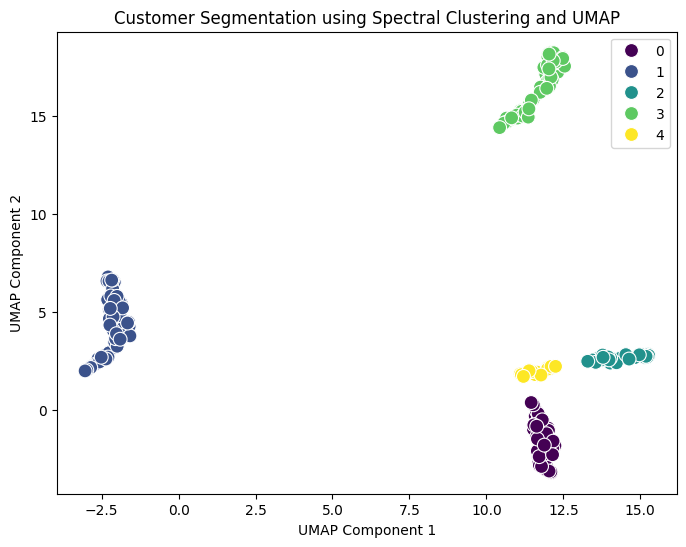

          TotalValue   Quantity  TransactionID  Cluster
Cluster                                                
0        3311.160870  12.891304       5.304348      0.0
1        3717.840000  13.372881       5.152542      1.0
2        2124.869231   7.961538       3.192308      2.0
3        3325.092600  11.900000       4.680000      3.0
4        5379.353889  19.611111       7.500000      4.0


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress deprecation warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress UMAP parallelism warning

# Load the datasets
customers = pd.read_csv('/content/drive/MyDrive/zeopat/Customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/zeopat/Transactions.csv')

# Merge datasets on CustomerID
data = pd.merge(customers, transactions, on='CustomerID')

# Aggregate transaction data for each customer
customer_agg = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'nunique'
}).reset_index()

# Merge aggregated data with customer profile
customer_data = pd.merge(customers, customer_agg, on='CustomerID')

# Encode categorical variables (Region)
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.drop(columns=['CustomerID', 'CustomerName', 'SignupDate']))

# Apply UMAP for dimensionality reduction
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=20, min_dist=0.1)  # Increased n_neighbors
umap_data = umap_reducer.fit_transform(scaled_data)

# Determine the optimal number of clusters using the Davies-Bouldin Index
best_db_index = float('inf')
best_clusters = None
best_n_clusters = 2

for n_clusters in range(2, 11):
    spectral = SpectralClustering(
        n_clusters=n_clusters,
        affinity='rbf',  # Changed to 'rbf' for better connectivity
        random_state=42
    )
    clusters = spectral.fit_predict(umap_data)
    db_index = davies_bouldin_score(umap_data, clusters)

    if db_index < best_db_index:
        best_db_index = db_index
        best_clusters = clusters
        best_n_clusters = n_clusters

print(f"Davies-Bouldin Index: {best_db_index}")
print(f"Optimal Number of Clusters: {best_n_clusters}")

# Add cluster labels to the data
customer_data['Cluster'] = best_clusters

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], hue=best_clusters, palette='viridis', s=100)
plt.title('Customer Segmentation using Spectral Clustering and UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

# Analyze cluster characteristics
numerical_columns = customer_data.select_dtypes(include=[np.number]).columns
cluster_summary = customer_data.groupby('Cluster')[numerical_columns].mean()

print(cluster_summary)